<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

# Table of Contents
## [Importing of packages](#import)
## [Step 1: Problem Statement Formulation](#statement)
## [Step 2: Exploratory Data Analysis and Data Cleansing](#clean)
## [Step 3: Data Wrangling and Transformation](#transform)
## [Step 4: Train Test Split](#tts)
## [Step 5: Consolidating of columns and scaling](#scaling)
## [Step 6: Machine Learning Modelling](#model)
## [Step 7: Model Evaluation and Selection](#select)
## [Step 8: Report](#report)

## Importing of packages <a id="import"></a>

In [1]:
# import the packages
from pyspark.sql import SparkSession

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, avg

from pyspark.sql.functions import col, isnan, when, count

from pyspark.ml.feature import Imputer

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.feature import StandardScaler

from pyspark.ml.regression import LinearRegression

## Step 1: Problem Statement Formulation <a id="statement"></a>

### Loading of Data

In [2]:
# load and explore data
spark=SparkSession.builder.appName('ASG1').getOrCreate()
df_pyspark_housing=spark.read.csv('./data/sg_flat_prices_mod.csv', header=True, inferSchema=True) 

In [3]:
df_pyspark_housing.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)



In [4]:
df_pyspark_housing.show(5)

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  465|ANG MO KIO AVE 10|    04 TO 06|          68.0|New Generation|

## Step 2: Exploratory Data Analysis and Data Cleansing <a id="clean"></a>

### Exploring the Data

#### Distinct values of remaining lease

In [5]:
df_pyspark_housing.select('remaining_lease').distinct().collect()

[Row(remaining_lease=833),
 Row(remaining_lease=1088),
 Row(remaining_lease=737),
 Row(remaining_lease=858),
 Row(remaining_lease=897),
 Row(remaining_lease=1127),
 Row(remaining_lease=1025),
 Row(remaining_lease=1084),
 Row(remaining_lease=623),
 Row(remaining_lease=1139),
 Row(remaining_lease=1143),
 Row(remaining_lease=808),
 Row(remaining_lease=580),
 Row(remaining_lease=883),
 Row(remaining_lease=879),
 Row(remaining_lease=799),
 Row(remaining_lease=970),
 Row(remaining_lease=588),
 Row(remaining_lease=804),
 Row(remaining_lease=898),
 Row(remaining_lease=1157),
 Row(remaining_lease=853),
 Row(remaining_lease=1005),
 Row(remaining_lease=1016),
 Row(remaining_lease=1133),
 Row(remaining_lease=918),
 Row(remaining_lease=961),
 Row(remaining_lease=974),
 Row(remaining_lease=857),
 Row(remaining_lease=673),
 Row(remaining_lease=633),
 Row(remaining_lease=613),
 Row(remaining_lease=1160),
 Row(remaining_lease=976),
 Row(remaining_lease=876),
 Row(remaining_lease=593),
 Row(remaining_le

#### Remaining lease less than or equal to 99 

In [6]:
df_pyspark_housing.filter("remaining_lease<=99").show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



#### Null count of each column

In [7]:
df_pyspark_housing.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark_housing.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|   0|    0|   0|        0|    0|          0|           0|            50|         0|                  0|              0|           0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



#### Viewing of rows with nulls 

In [8]:
filtered_null = df_pyspark_housing.filter(df_pyspark_housing.floor_area_sqm.isNull())
filtered_null.show(50)

+----+-----+---------------+---------+-----+------------------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|           town|flat_type|block|       street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+---------------+---------+-----+------------------+------------+--------------+----------+-------------------+---------------+------------+
|2017|    3|     QUEENSTOWN|   4 ROOM|  161|       MEI LING ST|    19 TO 21|          null|  Improved|               1970|            628|    556000.0|
|2017|    3|      TOA PAYOH|   4 ROOM|  220|   LOR 8 TOA PAYOH|    16 TO 18|          null|  Improved|               1976|            698|    383000.0|
|2017|    3|      TOA PAYOH|   4 ROOM|  213|   LOR 8 TOA PAYOH|    16 TO 18|          null|  Improved|               1975|            683|    390000.0|
|2017|    3|      TOA PAYOH|   4 ROOM|  204|     TOA PAYOH NTH|    13 TO 15|          nu

#### Viewing the values of flat type and flat model for the rows with nulls

In [9]:
filtered_null.select('flat_type').distinct().collect()

[Row(flat_type='4 ROOM')]

In [10]:
filtered_null.select('flat_model').distinct().collect()

[Row(flat_model='Improved')]

### Data Cleaning 

#### Finding the mean of the floor area sqm for improved and 4 room flats and replacing null values

In [11]:
mean = df_pyspark_housing.filter((df_pyspark_housing['flat_type']=='4 ROOM') &
                  (df_pyspark_housing['flat_model']=='Improved')).groupBy().agg(avg(col("floor_area_sqm")))

In [12]:
mean = round(mean.take(1)[0][0])

In [13]:
mean

85

In [14]:
#check if all null values are replaced
df_pyspark_housing = df_pyspark_housing.na.fill(mean,['floor_area_sqm'])
df_pyspark_housing.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark_housing.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|   0|    0|   0|        0|    0|          0|           0|             0|         0|                  0|              0|           0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



#### Dropping of unnecessary columns

In [15]:
df_pyspark_housing = df_pyspark_housing.drop('block','lease_commence_date') 
df_pyspark_housing.show()

+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+
|year|month|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|remaining_lease|resale_price|
+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+
|2017|    1|ANG MO KIO|   2 ROOM|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|            736|    232000.0|
|2017|    1|ANG MO KIO|   3 ROOM| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|            727|    250000.0|
|2017|    1|ANG MO KIO|   3 ROOM| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|            749|    262000.0|
|2017|    1|ANG MO KIO|   3 ROOM|ANG MO KIO AVE 10|    04 TO 06|          68.0|New Generation|            745|    265000.0|
|2017|    1|ANG MO KIO|   3 ROOM| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|            749|    265000.0|
|2017|  

## Step 3: Data Wrangling and Transformation <a id="transform"></a>

### Distribution of numerical variables

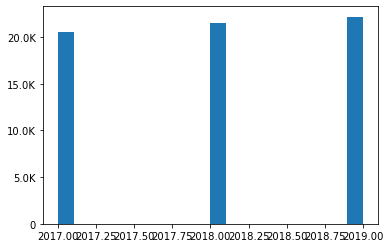

In [16]:
fig, ax = plt.subplots()
hist(ax, df_pyspark_housing.select('year'), bins = 20)
plt.show()

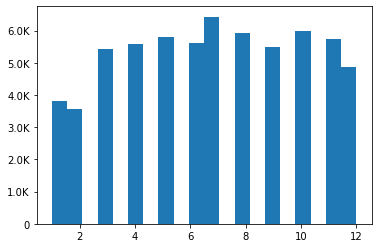

In [17]:
fig, ax = plt.subplots()
hist(ax, df_pyspark_housing.select('month'), bins = 20)
plt.show()

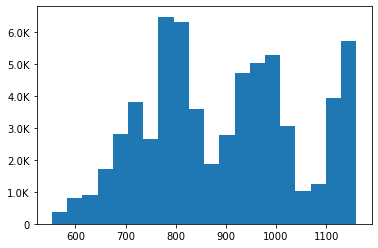

In [18]:
fig, ax = plt.subplots()
hist(ax, df_pyspark_housing.select('remaining_lease'), bins = 20)
plt.show()

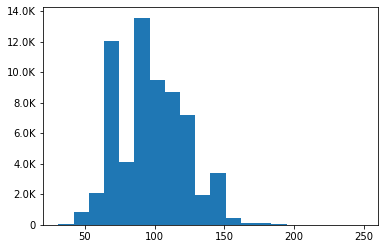

In [19]:
fig, ax = plt.subplots()
hist(ax, df_pyspark_housing.select('floor_area_sqm'), bins = 20)
plt.show()

### Encoding of Categorical data using One Hot Encoding 

In [20]:
strings_used = ["town", "flat_type", "street_name", "storey_range", "flat_model"]

stage_string = [StringIndexer(inputCol= c, outputCol= c +"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c +"_string_encoded", outputCol= c + "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
df_pyspark_housing_ohe = ppl.fit(df_pyspark_housing).transform(df_pyspark_housing)
df_pyspark_housing_ohe.show(5)

+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+-------------------+--------------------+------------------+
|year|month|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|remaining_lease|resale_price|town_string_encoded|flat_type_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|
+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+-------------------+------------

## Step 4: Train Test Split <a id="tts"></a>

In [21]:
(train, test) = df_pyspark_housing_ohe.randomSplit([0.8, 0.2], seed=42)

## Step 5: Consolidating of columns and scaling <a id="scaling"></a>

### Showing number of columns and rows before consolidating of X columns

In [22]:
train.count(), len(train.columns)

(51406, 20)

In [23]:
test.count(), len(test.columns)

(12841, 20)

### Consolidating of X columns

In [24]:
inputCols = df_pyspark_housing_ohe['year','month','floor_area_sqm','remaining_lease','town_string_encoded','flat_type_string_encoded','street_name_string_encoded','storey_range_string_encoded','flat_model_string_encoded','town_one_hot','flat_type_one_hot','street_name_one_hot','storey_range_one_hot','flat_model_one_hot']

In [25]:
featureassembler=VectorAssembler(inputCols=inputCols.columns,outputCol="Xcols")

In [26]:
train_vectored = featureassembler.transform(train)

In [27]:
train_vectored.show(5)

+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+-------------------+--------------------+------------------+--------------------+
|year|month|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|remaining_lease|resale_price|town_string_encoded|flat_type_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|
+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+--------

In [28]:
test_vectored = featureassembler.transform(test)

In [29]:
test_vectored.show(5)

+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+-------------------+--------------------+------------------+--------------------+
|year|month|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|remaining_lease|resale_price|town_string_encoded|flat_type_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|
+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+--------

### Standard scaling

In [30]:
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [31]:
train_sscaled = sScaler.fit(train_vectored).transform(train_vectored)
train_sscaled.show(5)

+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+-------------------+--------------------+------------------+--------------------+--------------------+
|year|month|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|remaining_lease|resale_price|town_string_encoded|flat_type_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|       Xcols_sscaled|
+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------

In [32]:
test_sscaled = sScaler.fit(test_vectored).transform(test_vectored)
test_sscaled.show(5)

+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------------------------+--------------+-----------------+-------------------+--------------------+------------------+--------------------+--------------------+
|year|month|      town|flat_type|      street_name|storey_range|floor_area_sqm|    flat_model|remaining_lease|resale_price|town_string_encoded|flat_type_string_encoded|street_name_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|street_name_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|       Xcols_sscaled|
+----+-----+----------+---------+-----------------+------------+--------------+--------------+---------------+------------+-------------------+------------------------+--------------------------+---------------------------+-------

## Step 6: Machine Learning Modelling <a id="model"></a>

### Final Tidy up and Check before Modelling 

In [33]:
train_data = train_sscaled.select("Xcols_sscaled","resale_price") #selecting the necessary columns needed
train_data.show(10) #showing a sample of 10 rows

+--------------------+------------+
|       Xcols_sscaled|resale_price|
+--------------------+------------+
|[-1.2578814265840...|    232000.0|
|[-1.2578814265840...|    285000.0|
|[-1.2578814265840...|    330000.0|
|[-1.2578814265840...|    338000.0|
|[-1.2578814265840...|    288500.0|
|[-1.2578814265840...|    285000.0|
|[-1.2578814265840...|    306000.0|
|[-1.2578814265840...|    298000.0|
|[-1.2578814265840...|    375000.0|
|[-1.2578814265840...|    325000.0|
+--------------------+------------+
only showing top 10 rows



In [34]:
train_data.count(), len(train_data.columns) #showing the number of rows and columns in the final train dataset

(51406, 2)

In [35]:
test_data = test_sscaled.select("Xcols_sscaled","resale_price")
test_data.show(10) #showing a sample of 10 rows

+--------------------+------------+
|       Xcols_sscaled|resale_price|
+--------------------+------------+
|[-1.2668088746839...|    297000.0|
|[-1.2668088746839...|    280000.0|
|[-1.2668088746839...|    265000.0|
|[-1.2668088746839...|    366000.0|
|[-1.2668088746839...|    312000.0|
|[-1.2668088746839...|    250000.0|
|[-1.2668088746839...|    265000.0|
|[-1.2668088746839...|    410000.0|
|[-1.2668088746839...|    425888.0|
|[-1.2668088746839...|    425888.0|
+--------------------+------------+
only showing top 10 rows



In [36]:
test_data.count(), len(test_data.columns) #showing the number of rows and columns in the final train dataset

(12841, 2)

### Building of Predictive Model

In [37]:
regressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol='resale_price')
regressor=regressor.fit(train_data)

## Step 7: Model Evaluation and Selection <a id="select"></a>

In [38]:
train_pred_results=regressor.evaluate(train_data)
train_pred_results.predictions.show()

+--------------------+------------+------------------+
|       Xcols_sscaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2578814265840...|    232000.0| 201817.5286365393|
|[-1.2578814265840...|    285000.0| 293923.3186198961|
|[-1.2578814265840...|    330000.0|334504.20806961047|
|[-1.2578814265840...|    338000.0|334504.20806961047|
|[-1.2578814265840...|    288500.0|270706.46308068756|
|[-1.2578814265840...|    285000.0|283958.22240294504|
|[-1.2578814265840...|    306000.0| 291616.5974079007|
|[-1.2578814265840...|    298000.0| 300563.3588682398|
|[-1.2578814265840...|    375000.0| 349420.6457322447|
|[-1.2578814265840...|    325000.0| 299776.6169614082|
|[-1.2578814265840...|    325000.0|276851.11790557357|
|[-1.2578814265840...|    285000.0| 287287.9175750739|
|[-1.2578814265840...|    295000.0| 295112.5410691912|
|[-1.2578814265840...|    298000.0| 296782.4290163112|
|[-1.2578814265840...|    328000.0| 303879.4527915715|
|[-1.25788

In [39]:
test_pred_results=regressor.evaluate(test_data)
test_pred_results.predictions.show()

+--------------------+------------+------------------+
|       Xcols_sscaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2668088746839...|    297000.0|316044.56898547884|
|[-1.2668088746839...|    280000.0| 284591.8076149045|
|[-1.2668088746839...|    265000.0| 287519.1243288758|
|[-1.2668088746839...|    366000.0|  357825.450909637|
|[-1.2668088746839...|    312000.0|  319253.892513287|
|[-1.2668088746839...|    250000.0| 262084.9168281918|
|[-1.2668088746839...|    265000.0| 266427.1457642007|
|[-1.2668088746839...|    410000.0| 380644.6673625933|
|[-1.2668088746839...|    425888.0| 419933.3391195074|
|[-1.2668088746839...|    425888.0| 419933.3391195074|
|[-1.2668088746839...|    425888.0| 419933.3391195074|
|[-1.2668088746839...|    403000.0| 393396.3646404483|
|[-1.2668088746839...|    435000.0|387715.03389972507|
|[-1.2668088746839...|    756000.0| 764521.7487119429|
|[-1.2668088746839...|    888000.0| 744524.3757970282|
|[-1.26680

In [40]:
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(29662.764143350476, 1575875046.0130105, 0.9331252743037551)

In [41]:
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(30055.791208948827, 1610842630.2332659, 0.9327441287551993)

## Step 8: Report <a id="report"></a>

### Table of Contents
#### [1. Problem Statement Formulation](#rstatement)
#### [2. Exploratory Data Analysis and Data Cleansing](#rclean)
#### [3. Data Wrangling and Transformation](#rtransform)
#### [4. Machine Learning Modelling](#rmodel)
#### [5. Model Evaluation and Selection](#rselect)
#### [6. Summary and Further Improvements](#rimprove)

#### 1. Problem Statement Formulation <a id="rstatement"></a>

The objective of this assignment was to build a machine learning model using PySpark. A transaction dataset of HDB resale flats was loaded into a data frame and the provided variables were analysed. The schema of the data frame was displayed to view the data type of the variables and determine whether the variables can be null. After understanding the data, I realised that a machine learning model to predict the potential market price of a HBD flat can be built, which will benefit both individuals and organisations. Individuals will be able to use the prediction to determine when the best time is to buy or sell their house while organisations such as property agencies can also use the prediction to advise the buyer or seller on the appropriate time to buy or sell their house.     

#### 2. Exploratory Data Analysis and Data Cleansing <a id="rclean"></a>

After formulating the problem statement, I explored the data to have a better idea of what needs to be cleaned. Firstly, with the assumption that the remaining lease period of HDB resale flats are in years, I noticed that the remaining lease in the data was greater than the maximum 99-year lease period. 
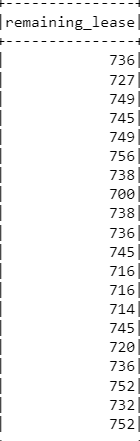
Further manual computation revealed that the remaining lease period was displayed in months instead of years. However, I did not convert it to years as I felt that having it in months was sufficient. 

I also checked for null values. After filtering, I realised that the null values are found in the floor area sqm variable of some transactions with 4-room flat type and improved flat model. 
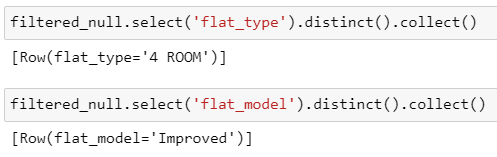
Instead of using mean imputation, whereby the mean of all the floor area sqm is calculated and the null values are imputed by this mean, I decided to find the average floor area sqm of 4-room flat type and improved flat model and replace the null values with that value. It made more sense to do it this way as the replaced values will be more accurate for prediction. 

Afterward, I dropped unnecessary columns such as block and lease commence date as they are not useful in predicting the resale price based on my data analysis.
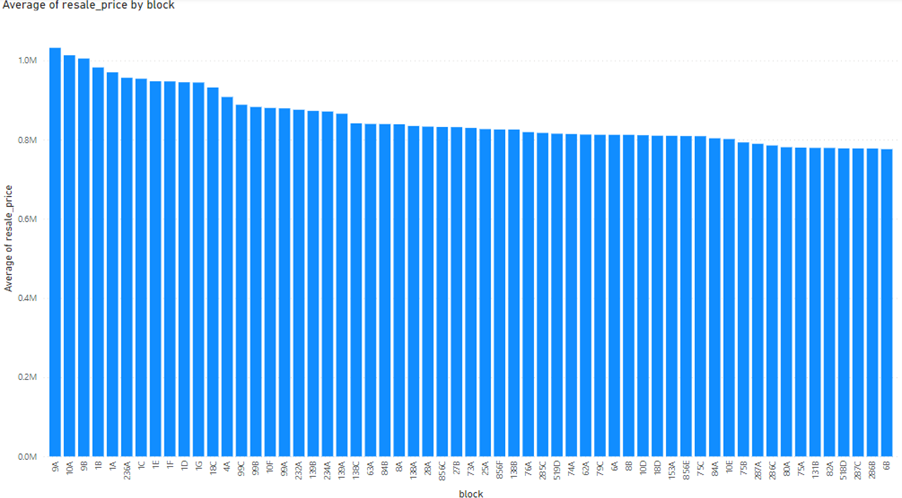
The average resale price is about the same across all blocks. Hence, block will not help much in predicting the resale price. 

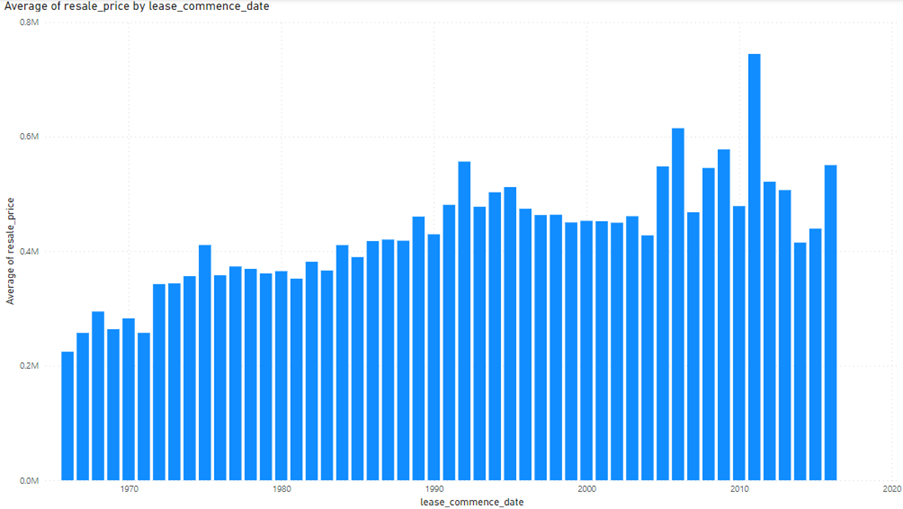
As for lease commencement date, although generally it can be seen that over the years, the resale price increases, this information has been reflected in the remaining lease variable as shown in the graph below. Hence, this variable is not needed. 

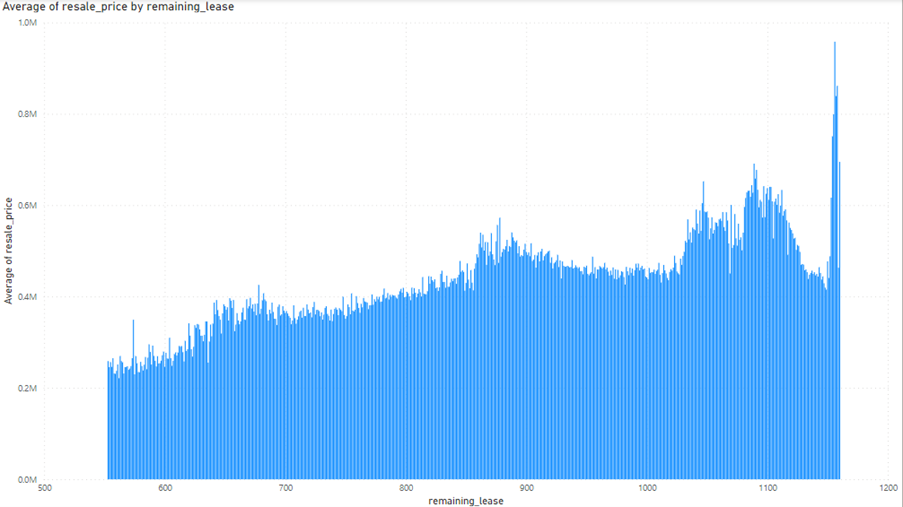
As for outliers, although the floor area sqm and resale price will possibly have outliers, I will not be considering the outliers as it is essential in training the model and not ideal to remove. 

#### 3. Data Wrangling and Transformation <a id="rtransform"></a>

After cleaning of the data, I looked at the distribution of the numerical variables and realised that it is not normally distributed. However, when I transformed these numerical variables using log transformation, the results of the model decreased (will be touched on in model evaluation and selection part) and the distribution did not seem to become more normally distributed. Hence, I did not do numerical transformation. 

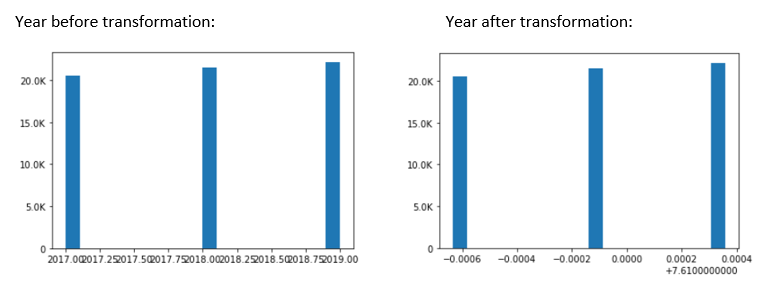

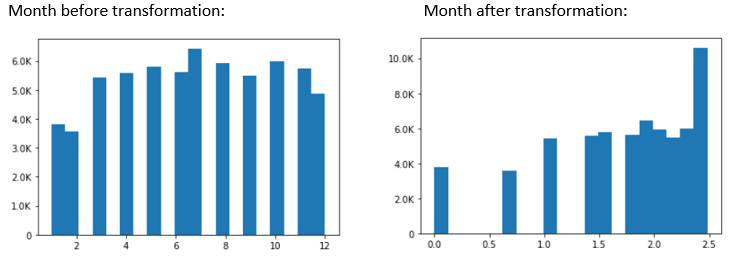

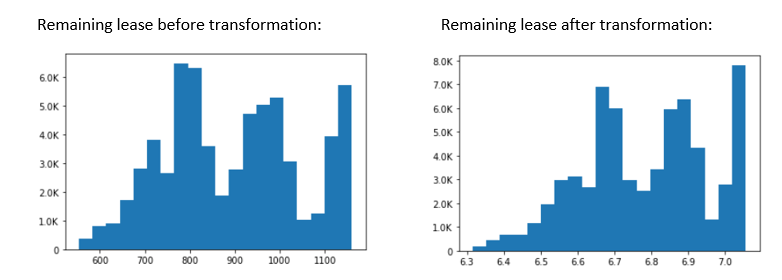

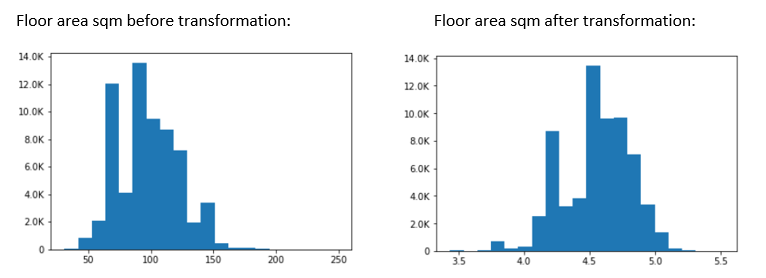

There is a need to perform categorical data encoding as some of the data are in categorical format. Most models are not able to handle categorical variables, hence the need to do encoding so that all the data are in numerical format. I used one hot encoding to encode the categorical data. Before performing one hot encoding, there is a need to perform string encoding first, which will convert string variables to numerical value. Performing string encoding first, followed by one hot encoding is a workflow which can be represented by a pipeline and the pipeline will run and transform the input data frame based on the sequence specified in the workflow. After encoding, I did train test split to split the data into train and test data and consolidated all the necessary columns that are required to predict the resale price of the flats into a column called ‘Xcols’ in both the train and test data frame. 
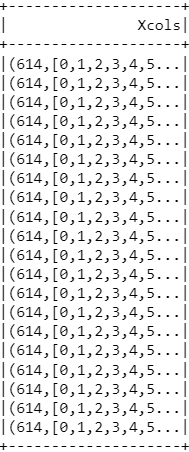

This makes it easier to perform scaling on only the necessary data and also for feeding it into the model later. After that, I did standard scaling on the Xcols variable as it consists of different ranges of numerical values. As machine learning algorithms are sensitive to the scale and magnitude of variables, scaling will standardise the variables in a fixed range and the machine learning algorithm will be able to provide a more accurate prediction. 

#### 4. Machine Learning Modelling <a id="rmodel"></a>

After preparing the data for modelling, I finalised and selected the columns, ‘Xcols_sscaled’ and ‘resale price’, which I will be using in training the machine learning model. The train data will have 51406 rows and 2 columns while the test data will have 12841 rows and 2 columns. I also showed a sample of 10 rows of data in the final train and test dataset. Since I chose to have only 2 columns of data in my final train and test dataset despite having a lot more data on hand, by showing a sample of 10 rows of the data can help to show that my predictions are not trivial or unrealistic if the predictive model achieved a good accuracy score. After that, I built a linear regression model since my problem statement is a regression problem. LabelCol would be the target feature which is ‘resale price’ since I want to predict the resale price of HDB flats, and featuresCol will be the list of features from the data frame, which will be ‘Xcols_sscaled’. 

#### 5. Model Evaluation and Selection <a id="rselect"></a>

After building the linear regression model and viewing the metrics, I was satisfied with the first model performance, but I wanted to explore alternative approaches for a more confident final model selection. 

For my first trial, I imputed the null values with the mean of the floor area sqm of 4-room and improved flats, did categorical encoding and standard scaling. 

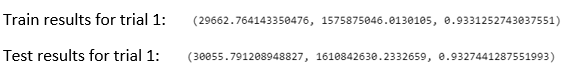

These results will serve as a guide to be compared to other trials. 

For my second and third trial, I wanted to see if dropping the null values or imputing the null values with the mean of all the floor area sqm provided respectively, will improve the model’s performance.  

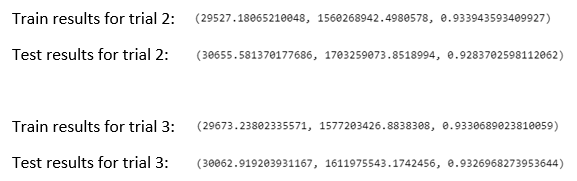

Compared to the first trial, the model performance for the third trial dropped slightly, justifying my choice of imputing null values with the mean of the floor area sqm of 4-room and improved flats. As for the model performance of the second trial, the train results improved but the test results decreased. This could be because since the null values are related to 4-room and improved flats, dropping these rows will make the test results decrease as there may not be enough data to train the model to predict the resale price of those flat type and model more accurately.

For my 4th trial, I tried to do numerical transformation. I used log transformation to transform the numerical variables to make it more normally distributed. However, the results for both train and test decreased.  

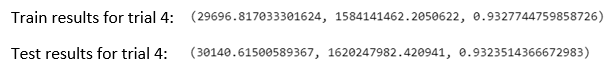

For my 5th trial, I used min max scaling, but the test results decreased drastically, showing overfitting and that min max scaling is not suitable for this dataset.    

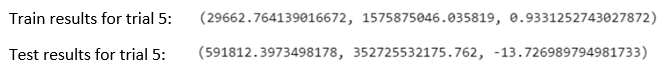

Hence, for my final model, I used the modelling methods from my first trial. 

#### 6. Summary and Further Improvements <a id="rimprove"></a>

In summary, I believe that with the data given and the unfamiliarity of using pyspark to prepare the dataset to build a machine learning model, the final model that I have selected is the best performance that the model can achieve at this point in time.

When preparing the data for modelling, we also need to be careful to ensure that we are not dropping too many rows of data with similar factors as it can affect the accuracy of predicting the resale price based on certain factors. 

There can be considerations for further improvements such as taking a deeper look into the outliers and deciding whether to cap them, or experiment with more categorical encoding, numerical transformation and scaling methods to get a better model performance. There can also be a consideration to group data together, such as for example, grouping of the floor area sqm values to small, medium, large. By doing this, it can help to provide more insights on the pattern of floor area sqm and help in the accuracy of predicting the price of the resale flats. 

### "Unlisted" Youtube Link to Video Presentation

In [42]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/phJCoefAvUo